# Federal Lands Analysis for DBCP
The following script calculates the percentage of protected area by county for the United States, both for all protected area and by sub-category.

## Data sources
Input data sources:
USGS Protected Areas Database (2022) GeoPackage, downloaded from: https://www.sciencebase.gov/catalog/item/managerRequestDownload/61794fc2d34ea58c3c6f9f69?filePath=https%3A%2F%2Fprod-is-usgs-sb-prod-content.s3.amazonaws.com%2F61794fc2d34ea58c3c6f9f69%2FPADUS3_0Geopackage.zip

2022 TIGER/LINE county shapefiles from the US Census: https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2022.html#list-tab-2NC0H2HC0MK5KAZOEM 

2021 Cartographic Boundary File shapefiles from the US Census: https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html

US Detailed Water Bodies from ESRI: https://hub.arcgis.com/datasets/esri::usa-detailed-water-bodies/about

### Step 1: Prepare county shapefiles for analysis.
The most accurate county shapefiles for calculating areas are TIGER/LINE county shapefiles from the US Census. However, these shapefiles include both marine and hydrologic areas in their perimeters, such as lakes and ponds. This will prevent us from accurately calculating the terrestrial area covered by different types of protected areas. The first step of analysis is to remove major bodies of water from our county shapefiles.

In [136]:
import geopandas as gpd
import pandas as pd

In [137]:
# Read in data
counties = gpd.read_file('counties/tl_2022_us_county.shp')
pa = gpd.read_file('protected_areas/PADUS3_0Geopackage.gpkg')

# Reproject counties to match protected areas dataset.
counties = counties.to_crs(pa.crs)

In [138]:
# Clip county shapefiles to remove surface water bodies.
sw_us = gpd.read_file('sw_bodies/USA_Detailed_Water_Bodies.shp')
sw_perennial = sw_us[sw_us.FTYPE == "Lake/Pond"]
sw_perennial = sw_perennial.to_crs(counties.crs)

In [139]:
# To improve computational speed, target the largest 10% of lakes and ponds for analysis.
sw_perennial.SQKM.quantile(0.90) # 90th percentile: 0.18 sq. km

sw_sub = sw_perennial[sw_perennial.SQKM>sw_perennial.SQKM.quantile(0.90)]

In [140]:
# Remove these bodies of water from counties
counties_nowater = counties.overlay(sw_sub, how = 'symmetric_difference')
counties_nowater = counties_nowater[counties_nowater.GEOID.notnull()] # Remove lake geometries

/home/thinky/mambaforge/envs/pudl-dev/lib/python3.10/site-packages/geopandas/geodataframe.py:2323: UserWarning: `keep_geom_type=True` in overlay resulted in 18 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


In [141]:
# The most accurate TIGER shapefiles project past the coastline, skewing area measurements.
# As we're interested in land area, we use the Cartographic Boundary Files also provided by the US Census
# to clip county shapefiles to the US coastline.
cbf = gpd.read_file('cb_2021_us_county_500k/cb_2021_us_county_500k.shp')

In [142]:
# Clip county shapefiles to coastline
cbf = cbf.to_crs(counties_nowater.crs)
counties_clip = counties_nowater.clip(cbf, keep_geom_type = True)
counties_clip = counties_clip.dissolve(by='GEOID').reset_index()

In [143]:
# Drop all records that are not part of the 50 U.S. states
counties_clip = counties_clip[pd.to_numeric(counties_clip.STATEFP)<60]

In [144]:
counties_clip['terrestrial_area_km2'] = counties_clip.area / (1000**2) # Default unit in meters.

# TIGER shapefiles derive from sources with a variety of accuracies. We round to the nearest kilometer squared here for this first pass analysis.
# https://www2.census.gov/geo/pdfs/maps-data/data/tiger/tgrshp2022/TGRSHP2022_TechDoc_Ch3.pdf
counties_clip['terrestrial_area_km2'] =  counties_clip.terrestrial_area_km2.round(decimals = 0) # Round to nearest 10km2

### Step 2: Combine GAP data and perform analysis.

First we join the protected areas dataset to our county shapefiles. Then we filter for federally owned land with a GAP status of 3 or above.

Accuracy of PA dataset is at best 1000 hectares (10km2). So we should round data to the nearest 10km.
According to: https://www.sciencebase.gov/catalog/file/get/61794fc2d34ea58c3c6f9f69?f=__disk__05%2F77%2F0e%2F05770eaf5af2c67e6a920af6f4a1a2beffb39e19&transform=1&allowOpen=true


In [162]:
# Join protected areas dataset to county shapefiles.
gdf_joined = gpd.overlay(counties_clip,pa, how='intersection', keep_geom_type= True)

In [146]:
# Heeding warning about dropped geometries. Typically this is an outcome of polygons touching (e.g. parks along state borders),
# but we check to make sure nothing is being dropped that shouldn't be.

# gdf_test = gpd.overlay(counties_clip,pa, how='intersection', keep_geom_type= False)

# # All three changed records include linestrings (border intersections), which force the geometry to a collection instead of a multipolygon.
# # We can safely drop these by keeping geom_type to True.
# gdf_test[gdf_test.geom_type == 'GeometryCollection'].geometry

In [170]:
# Get area of each intersected area (each slice of a protected area in a county) (in km2).
gdf_joined['protected_area_km2'] = gdf_joined.area / (1000**2)
gdf_joined['protected_area_km2'] = gdf_joined.protected_area_km2.round(decimals = -1) # Round to nearest 10km2

In [173]:
#gdf_joined.to_file("pa_join.shp") # Save to shapefile
gdf_joined.drop('geometry',axis=1).to_csv("pa_join_database.csv", index = False) # Save non-spatial columns to csv

#counties_clip.to_file("clipped_counties.shp") # Save clipped county shapefiles
counties_clip.drop('geometry',axis=1).to_csv("counties_clip.csv", index = False) # Save non-spatial columns to csv

In [161]:
# Write this and the counties clipped out as a csv for future analysis.


0         1546.0
1         2569.0
2         2307.0
3         1546.0
4         1546.0
           ...  
263027    6215.0
263028    6215.0
263029    6215.0
263030    6215.0
263031    6215.0
Name: terrestrial_area_km2, Length: 263032, dtype: float64

In [174]:
# Get sum total of all protected land (m2) in county
county_all_pa = gdf_joined.groupby(['GEOID', 'terrestrial_area_km2'])['protected_area_km2'].agg('sum').reset_index()
county_all_pa['all_protected_pct'] = county_all_pa['protected_area_km2']/(county_all_pa['terrestrial_area_km2'])

In [175]:
# All 'developable' land: Only keep land with a GAP status of 3 or above
# GAP status is never null in the dataset.
target_gap = ['3 - managed for multiple uses - subject to extractive (e.g. mining or logging) or OHV use', '4 - no known mandate for biodiversity protection']
gdf_gap = gdf_joined.loc[gdf_joined.GAP_Sts.isin(target_gap)]

county_gap = gdf_gap.groupby(['GEOID', 'terrestrial_area_km2'])['protected_area_km2'].agg('sum').reset_index()
county_gap['gap3+_pct'] = county_gap['protected_area_km2']/(county_gap['terrestrial_area_km2'])

In [150]:
# Optional: plot to check we're dealing with what we think we're dealing with here.
# gdf_gap.plot() # Looks good!

In [176]:
# Federally managed land
county_fed = gdf_gap.loc[gdf_gap.Mang_Type == "FED"].groupby(['GEOID', 'terrestrial_area_km2'])['protected_area_km2'].agg('sum').reset_index()
county_fed['fed_managed_pct'] = county_fed['protected_area_km2']/(county_fed['terrestrial_area_km2'])


In [177]:
# Spot check for quality.
# 32009 is Esmerelda County, NV, almost all owned by BLM.
# 08053 is Hinsdale County, CO. 
county_fed[county_fed.fed_managed_pct>0.8]

,GEOID,terrestrial_area_km2,protected_area_km2,fed_managed_pct
58,02110,7291.0,6770.0,0.928542
60,02130,13381.0,12370.0,0.924445
68,02195,7945.0,7250.0,0.912524
70,02220,8302.0,7350.0,0.885329
73,02275,6942.0,6500.0,0.936330
135,06003,1916.0,1760.0,0.918580
158,06051,7897.0,6930.0,0.877548
212,08053,2898.0,2760.0,0.952381
224,08079,2271.0,2120.0,0.933509
232,08097,2516.0,2110.0,0.838633


In [178]:
# Tribally managed land
county_trib = gdf_gap.loc[(gdf_gap.Mang_Type == "TRIB")].groupby(['GEOID', 'terrestrial_area_km2'])['protected_area_km2'].agg('sum').reset_index()
county_trib['trib_managed_pct'] = county_trib['protected_area_km2']/(county_trib['terrestrial_area_km2'])

In [ ]:
#county_trib
# Spot check: 36033 is the Akwesasne reservation in Franklin County, NY

In [179]:
# BLM and USFS-managed only
county_usfsblm = gdf_gap.loc[(gdf_gap.Mang_Type == "FED")& gdf_gap.Mang_Name.isin(["USFS", "BLM"])].groupby(['GEOID', 'terrestrial_area_km2'])['protected_area_km2'].agg('sum').reset_index()
county_usfsblm['usfsblm_managed_pct'] = county_usfsblm['protected_area_km2']/(county_usfsblm['terrestrial_area_km2'])

In [180]:
# Join everything together

# First update the protected_area_km2 column name to be distinct.
county_all_pa.rename(columns = {'protected_area_km2': 'all_protected_km2'}, inplace = True)
county_gap.rename(columns = {'protected_area_km2': 'gap3+_km2'}, inplace = True)
county_fed.rename(columns = {'protected_area_km2': 'fed_owned_3+_km2'}, inplace = True)
county_trib.rename(columns = {'protected_area_km2': 'trib_owned_3+_km2'}, inplace = True)
county_usfsblm.rename(columns = {'protected_area_km2': 'usfs_blm_3+_km2'}, inplace = True)

In [181]:
county_final = county_all_pa.merge(county_gap, on = ['GEOID', 'terrestrial_area_km2'], how = 'left').merge(county_fed, on = ['GEOID', 'terrestrial_area_km2'], how = 'left').merge(county_usfsblm, on = ['GEOID', 'terrestrial_area_km2'], how = 'left').merge(county_trib, on = ['GEOID', 'terrestrial_area_km2'], how = 'left')
# Add back in counties with no protected lands
county_final = county_final.merge(counties_clip[['GEOID', 'terrestrial_area_km2']], how = 'outer')
county_final.rename(columns = {'GEOID': 'fips_code'}, inplace = True)



In [183]:
county_final.sample(100)

,fips_code,terrestrial_area_km2,all_protected_km2,all_protected_pct,gap3+_km2,gap3+_pct,fed_owned_3+_km2,fed_managed_pct,usfs_blm_3+_km2,usfsblm_managed_pct,trib_owned_3+_km2,trib_managed_pct
1290,26149,1322.0,10.0,0.007564,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
3110,17171,653.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1542,29149,2050.0,430.0,0.209756,430.0,0.209756,430.0,0.209756,430.0,0.209756,NaN,NaN
2728,48475,2164.0,340.0,0.157116,340.0,0.157116,NaN,NaN,NaN,NaN,NaN,NaN
3063,55095,2405.0,160.0,0.066528,30.0,0.012474,0.0,0.000000,0.0,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2721,48461,3212.0,350.0,0.108966,350.0,0.108966,NaN,NaN,NaN,NaN,NaN,NaN
2450,47083,519.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN
2284,42119,823.0,290.0,0.352369,260.0,0.315917,NaN,NaN,NaN,NaN,NaN,NaN
1463,28155,1096.0,40.0,0.036496,40.0,0.036496,10.0,0.009124,NaN,NaN,NaN,NaN


In [184]:
# Save file
county_final.to_csv("federal_lands_gap.csv")

Additional code below not used for analysis, but may be helpful.

<AxesSubplot: >

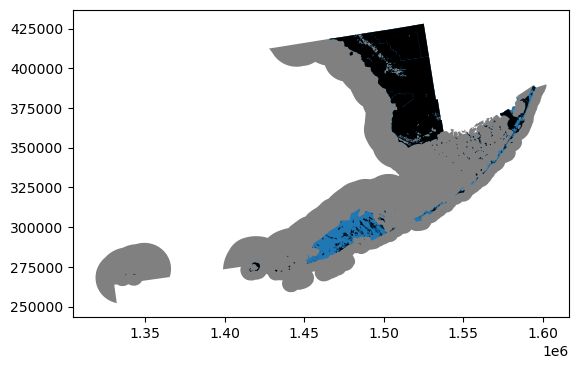

In [117]:
# The code below visualizes some of the edge cases associated with removing water from county shapefiles.
# In grey is the original TIGER shapefile.
# In blue is the trimmed TIGET shapefile (used for analysis in this study)
# In black is the protected area for this county.
# We can see in the difference between blue and black that very small marine areas in between coastal islands are still included.

import matplotlib.pyplot as plt
fig, ax = plt.subplots()

counties[(counties.STATEFP=="12")&(counties.COUNTYFP=='087')].plot(ax = ax, color = 'grey')
counties_clip[(counties_clip.GEOID=='12087')].plot(ax = ax)
gdf_joined[(gdf_joined.GEOID=='12087')].plot(ax = ax, color = 'black')


In [120]:
# Read in classification types - dictionary for keys
category = gpd.read_file('protected_areas/Category.dbf')
designation = gpd.read_file('protected_areas/Designation_Type.dbf')
gap_status = gpd.read_file('protected_areas/GAP_Status.dbf')
public_access = gpd.read_file('protected_areas/Public_Access.dbf')
agency_type = gpd.read_file('protected_areas/Agency_Type.dbf')

In [121]:
agency_type

,Code,Dom,geometry
0,FED,Federal,None
1,TRIB,American Indian Lands,None
2,STAT,State,None
3,DIST,Regional Agency Special District,None
4,LOC,Local Government,None
5,NGO,Non-Governmental Organization,None
6,PVT,Private,None
7,JNT,Joint,None
8,UNK,Unknown,None
9,TERR,Territorial,None
